# 波浪理论策略

In [3]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

# 回测框架
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeed

# 基础函数
import utilsJ

## 策略主体

### 思路
中钢天源(002057)过去一年(2021/09/22至2022/09/21)的股价收盘价波动为下图蓝线。

将其取7日平均之后可得橘线。

橘线可大致看成为该股票的波形。

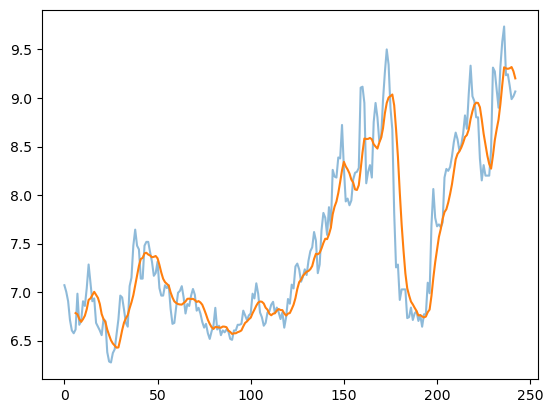

In [4]:
stock_code = '002057.SZ'
startdate = dt.datetime(2021,1,1)
enddate = dt.datetime(2021,12,31)
df = utilsJ.get_stock(stock_code, startdate, enddate)

plt.plot(range(len(df)), df.close, alpha = 0.5)
plt.plot(range(len(df)), df.close.rolling(7).mean())

对橘线进行求一阶导，可得以下趋势，其中每一次穿越 $y=0$ 表示波浪改变方向。

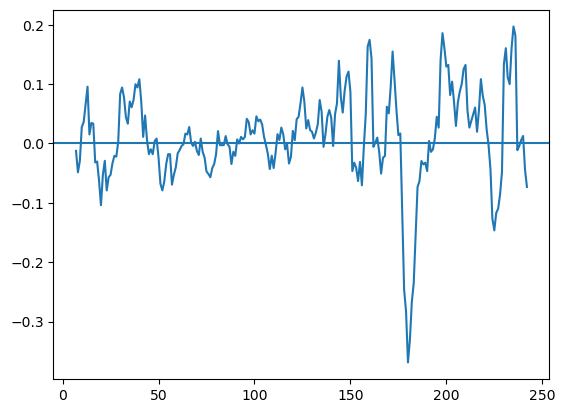

In [4]:
plt.plot(range(1, len(df)), np.diff(df.close.rolling(7).mean()))
plt.axhline(0)

### 策略细节

参数：
1. 日线平均周期，默认为5。
2. 信号栈长短，默认为3.

步骤：
1. 计算当日均线与昨日均线之差。如差值大于0，则向信号栈末尾添加‘上升’信号(1)；若差值小于等于0，则向信号栈末尾添加'下降'信号(-1)。
2. 如果信号栈呈现特定的排列，则释放买入/卖出信号。
3. 每次买入100股，每次全部卖出。

例如：
信号栈长短为3。

连续两天下跌，今日上涨，则信号栈为[-1, -1, 1]，可能是从调整浪变为上升浪，则进行买入；

连续两天上涨，今日下跌，则信号栈为[1, 1, -1]，可能是从上升浪变为调整浪，则进行卖出。

In [5]:
class Wave(bt.Strategy):
    
    params = (
        ('printlog', False),
        ('smoothing_period', 5),
        ('stack_len', 3),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Initialization
        self.order = None
        self.buyprice = None
        self.sellprice = None

        # Alias
        self.dataclose = self.data.close

        # Indicators
        ## SMA
        self.sma = btind.SMA(self.dataclose, period=self.p.smoothing_period)
        
        ## Singal stack
        self.stack = [0] * self.p.stack_len


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Cash: %i, Value: %i' %
                         (order.executed.price, order.executed.size,
                          self.broker.get_cash(), self.broker.get_value()))
                self.buyprice = order.executed.price

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Cash: %i, Value: %i' %
                        (order.executed.price, -order.executed.size,
                         self.broker.get_cash(), self.broker.get_value()))
                self.sellprice = order.executed.price

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next(self):

        if self.order:
            return
        
        for i in range(1, self.p.stack_len+1):
            self.stack[-i] = 1 if self.sma[-i+1] - self.sma[-i] > 0 else -1
        
        # Signals
        buy_s = self.stack[-1] == 1 and \
                sum(self.stack) in [-1*(self.p.stack_len-2), -1*(self.p.stack_len-3)]
        sell_s = self.stack[-1] == -1 and \
                 sum(self.stack) in [1*(self.p.stack_len-2), 1*(self.p.stack_len-3)]
        
        if buy_s:
            if self.buyprice is None:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                         (self.dataclose[0], 100, self.getposition(self.data).size))
                self.order = self.buy(size=100)            
            elif self.dataclose > self.buyprice:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                         (self.dataclose[0], 100, self.getposition(self.data).size))
                self.order = self.buy(size=100)
        elif sell_s:
                if self.getposition(self.data).size > 0:
                    self.log('SELL CREATE (Close), Price: %.2f, Lots: %i' % 
                             (self.dataclose[0], self.getposition(self.data).size))
                    self.order = self.close()

## 回测

### 个股回测

In [6]:
stock_code = '002057.SZ'
startdate = dt.datetime(2021,1,1)
enddate = dt.datetime(2021,12,31)

if __name__ ==  '__main__':
    
    # Initialization
    cerebro = bt.Cerebro()
    strats = cerebro.addstrategy(Wave,printlog=True, smoothing_period=7) 

    # Data
    df = utilsJ.get_stock(stock_code, startdate, enddate)
    data = btfeed.PandasData(dataname=df,fromdate=startdate,todate=enddate)
    cerebro.adddata(data)
    
    # Start conditions
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(2000)
    #cerebro.broker.setcommission()
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Execution
    cerebro.run()

    # Final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))
    #cerebro.plot(iplot=False)

Starting Portfolio Value: 2000.00
2021-01-18: BUY CREATE, Price: 6.91, Lots: 100, Current Position: 0
2021-01-19: BUY EXECUTED, Price: 6.91, Lot:100, Cash: 1309, Value: 1995
Final Portfolio Value: 2216.20
Net Profit: 10.81%


## 全市场回测

In [ ]:
profit_list = []
startdate = dt.datetime(2019,12,31)
enddate = dt.datetime(2021,12,31)

if __name__ == '__main__':

    stock_list = utilsJ.get_stock_list()
    for stk in stock_list:
        try:
            # Initialization
            cerebro = bt.Cerebro()
            strats = cerebro.addstrategy(Wave,printlog=False, smoothing_period=7) 

            # Data
            df = utilsJ.get_stock(stk, startdate, enddate)
            data = btfeed.PandasData(dataname=df,fromdate=startdate,todate=enddate)
            cerebro.adddata(data)
            
            # Start conditions
            cerebro.broker = bt.brokers.BackBroker(coc=True)
            cerebro.broker.setcash(10000)
            #cerebro.broker.setcommission()
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Execution
            cerebro.run()

            # Final result
            final_value = cerebro.broker.getvalue()
            #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            net_profit = (final_value - start_value) / start_value * 100
            profit_list.append((stk, net_profit))
        except:
            print(stk)

In [11]:
sorted(profit_list, key=lambda x: x[1], reverse=True)

[('603290.SH', 344.6498),
 ('300751.SZ', 338.2718),
 ('688202.SH', 300.82169999999996),
 ('688598.SH', 260.1593),
 ('002371.SZ', 255.89419999999996),
 ('600809.SH', 247.56980000000004),
 ('688356.SH', 242.40740000000005),
 ('300769.SZ', 232.39040000000003),
 ('688368.SH', 225.1023),
 ('002594.SZ', 216.49699999999999),
 ('002821.SZ', 210.9836),
 ('600702.SH', 195.94800000000004),
 ('002812.SZ', 193.99599999999998),
 ('688516.SH', 187.2532),
 ('600563.SH', 181.5187),
 ('000799.SZ', 173.43260000000004),
 ('000568.SZ', 163.09290000000001),
 ('603026.SH', 159.69400000000002),
 ('605117.SH', 158.458),
 ('688198.SH', 147.40260000000004),
 ('002791.SZ', 144.6757),
 ('300763.SZ', 143.15670000000003),
 ('603267.SH', 142.14800000000002),
 ('603392.SH', 140.55660000000003),
 ('688357.SH', 138.45450000000002),
 ('300672.SZ', 137.1619),
 ('300274.SZ', 134.4051),
 ('688133.SH', 134.20689999999996),
 ('002756.SZ', 129.92449999999997),
 ('300661.SZ', 128.3533),
 ('603486.SH', 127.93829999999997),
 ('60